In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time
import utils

import os

root = '../../dataset'
t_path = ['dataset_1790789260.csv',
          'dataset_1095394822.csv',
          'dataset_479911147.csv',
          'dataset_665254893.csv',
          
        ] 

s_path = ['dataset_320725673.csv',
          'dataset_401881001.csv',
          'dataset_1992961554.csv',
          'dataset_852552682.csv',
         ] 

l_path = ['dataset_327382690.csv',
          'dataset_395223984.csv',
          'dataset_1999618571.csv',
         ]

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

<IPython.core.display.Javascript object>


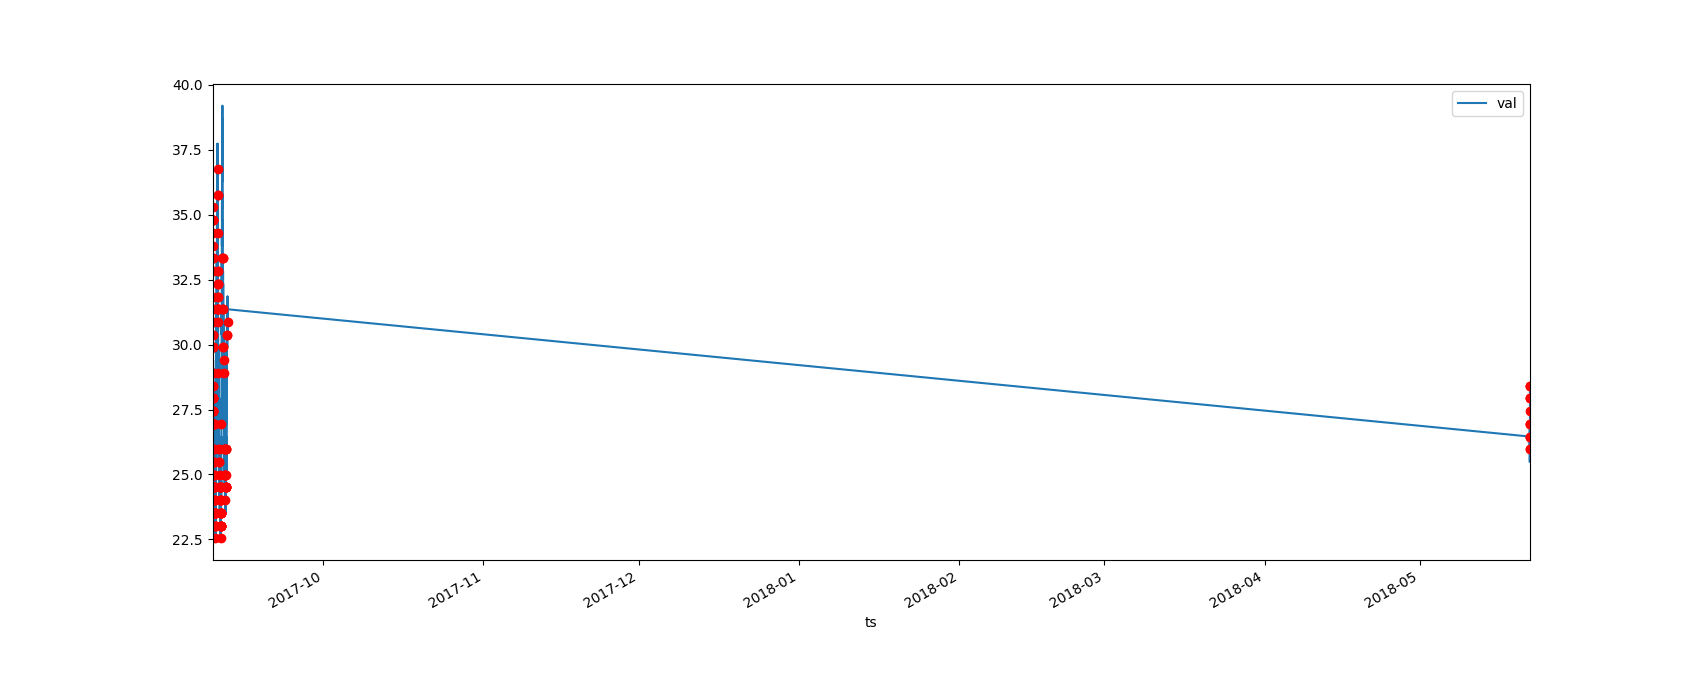

<IPython.core.display.Javascript object>


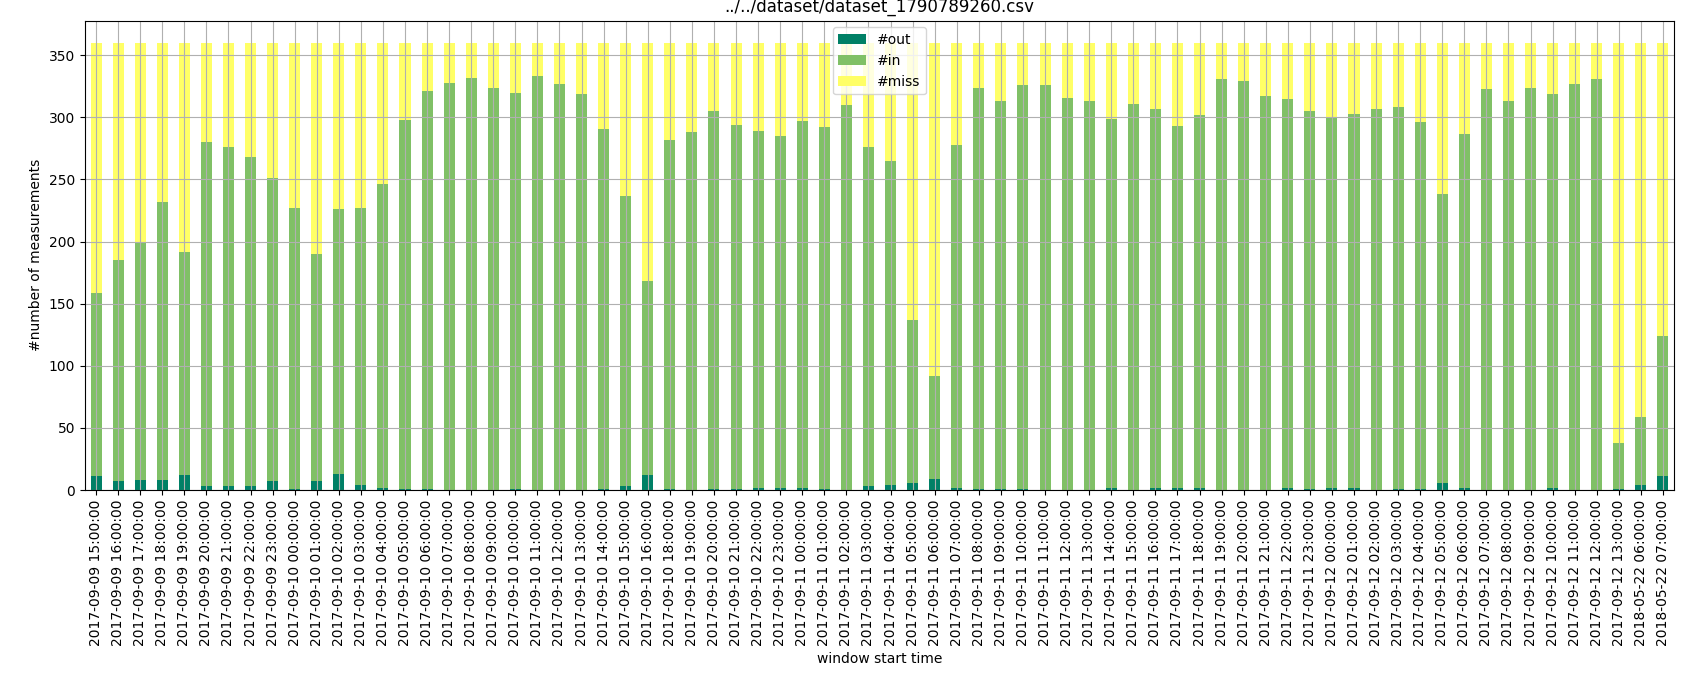

In [3]:
from sklearn.neighbors import LocalOutlierFactor
import math

def KNN_slider(df, mins = 60, val_index = 2, ts_index = 1, tr_secs = 10):
    
    delta = np.timedelta64(mins,'m')
    tr = np.timedelta64(tr_secs, 's')
    expected_num_measurements = int(delta / tr)
    
    win_col = ['id', 'start', 'stop', '#out', '#in', '#miss']
    win_ret = pd.DataFrame(columns = win_col)
    
    point_col = ['id', 'ts', 'val', 'is_in']
    point_ret = pd.DataFrame(columns = point_col)
    
    gen = utils.windows_generator(df, delta, ts_index)
    
    name = df.iloc[0,0]
    prev_window = pd.DataFrame()
    
    root = 2
    model = LocalOutlierFactor(n_neighbors=root, algorithm='auto', metric = 'euclidean', contamination='auto', n_jobs=1)
    
    for start, end, window in gen:
        if len(window) == 0:
            continue
        """
        if len(prev_window) < expected_num_measurements:
            prev_window = prev_window.append(window)
            continue
        """
        
        if len(prev_window) + len(window) < expected_num_measurements:
            prev_window = prev_window.append(window)
            continue
        
        curr_data = prev_window.append(window) 
        x = model.fit_predict(curr_data.iloc[:,1:2].values.reshape(-1,1))
        
        n_out = 0
        n_in = 0
        # count outliers
        j = len(prev_window.values)
        for i in range(len(window)):
            frame = window.iloc[i,:]
            
            ts = frame[ts_index].astype('datetime64[ms]')
            value = frame[val_index]
            out = x[j]
            if out == -1:
                n_out += 1
            else:
                n_in += 1
            
            j+=1
            
            new_data = pd.DataFrame([[name, ts, value, out]], columns = point_col)
            point_ret = point_ret.append(new_data, sort = False)
            
            prev_window = prev_window.append(frame)
            prev_window = prev_window.iloc[1:,:]
        
        win_data = pd.DataFrame([[name, start, end, n_out, n_in, expected_num_measurements-n_in-n_out]], columns = win_col)
        win_ret = win_ret.append(win_data, sort = False)
            
        
    return win_ret, point_ret


for x in [t_path[0], l_path[0], s_path[0]]:
    path = os.path.join(root, x)
    df = pd.read_csv(path, header=None)
    
    y, x = KNN_slider(df)
    fig, ax = plt.subplots()
    x.plot(ax = ax, x = 1, y = [2], kind='line')
    for l in x.values:
        ts = l[1]
        val = l[2]
        boolean = l[3]
        if boolean == -1:
            ax.plot(ts, val, 'ro-')
    ax.xaxis_date()
    '''
    values = x['value'].values
    predictions = x['predicted'].values
    error = values-predictions
    squared_error = np.square(error)
    plt.plot(np.arange(len(squared_error)), squared_error)
    plt.show()
    '''
    
    fig, ax = plt.subplots()
    fig.tight_layout()
    fig.subplots_adjust(left = 0.05, bottom=0.3)

    y.plot(x = 1, y = [3,4,5], ax = ax, kind = 'bar', stacked = 'True', colormap = 'summer', title = path)

    ax.set_xlabel('window start time')
    ax.set_ylabel('#number of measurements')
    ax.xaxis_date()
    ax.legend()
    ax.grid()
    
    break;

<IPython.core.display.Javascript object>


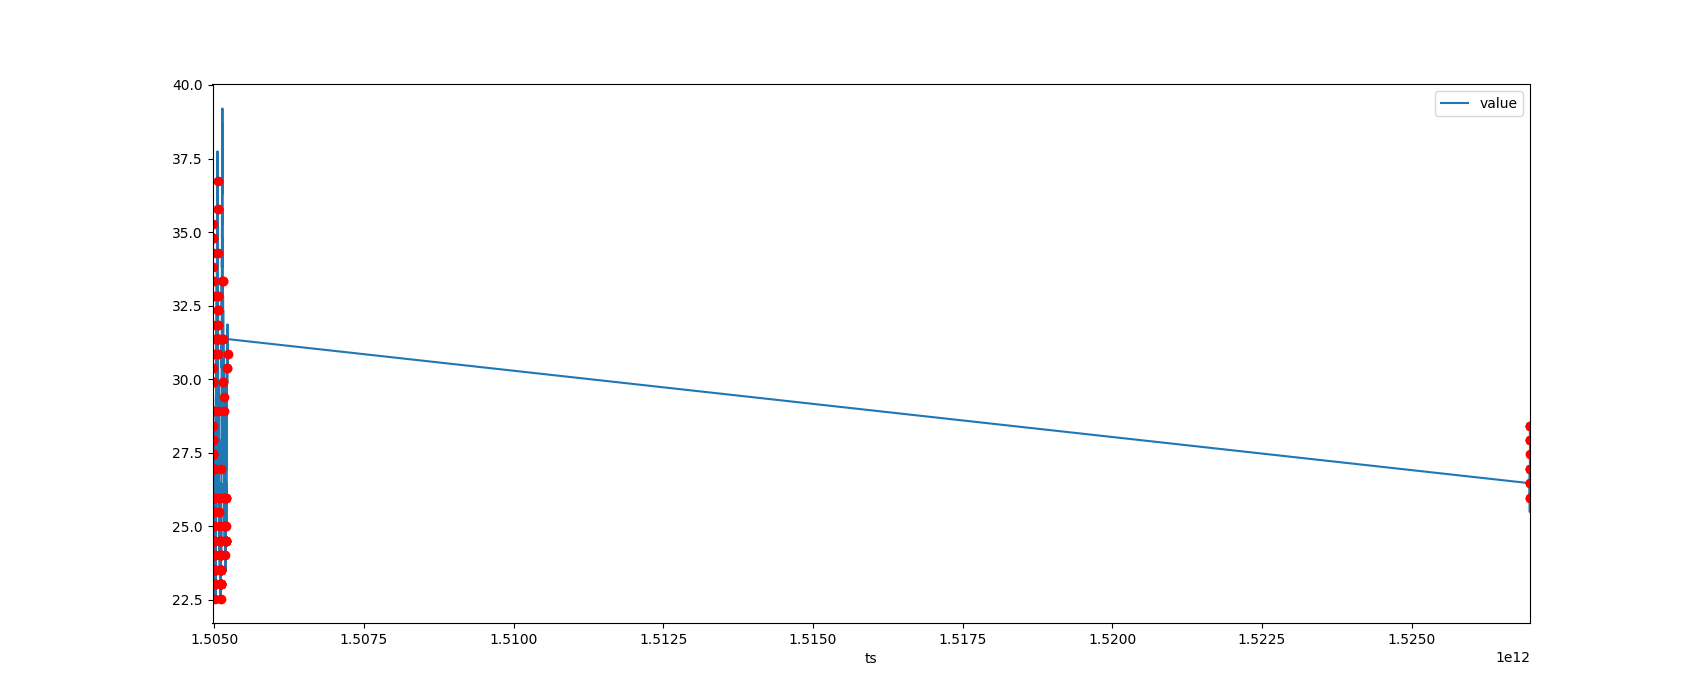

In [4]:
from sklearn.neighbors import LocalOutlierFactor
import math


def KNN_slider(df, mins = 60, overlap = 0, index = 2, tr_sec = 10):
    
    delta = np.timedelta64(mins,'m')
    
    tr = np.timedelta64(tr_sec, 's')
    expected_num_measurements = delta / tr
    #root = int(round(math.sqrt(expected_num_measurements)))
    root = 2
    
    delta = np.timedelta64(mins,'m')
    step = delta - np.timedelta64(overlap, 'm')
    
    first_delta = df.iloc[0, 1]
    first_delta = first_delta.astype('datetime64[ms]').astype('datetime64[h]').astype('datetime64[ms]')
                
    start = first_delta - step
    
    #cols = ['start', 'end', 'NOToutliers', 'outliers', 'missing']    
    cols = ['ts', 'value', 'Outlier?']
    ret = pd.DataFrame(columns = cols)
    info_ret = pd.DataFrame(columns = ['start','end','#out','#in', '#miss'])
    
    i = 0
    
    ret = pd.DataFrame(columns = cols)
    
    prev_window = pd.DataFrame()
    
    model = LocalOutlierFactor(n_neighbors=root, algorithm='auto', metric = 'euclidean', contamination='auto', n_jobs=1)
    
    while i < len(df):
       
        # populate a time window
        window = []
        start = start + step
        end = start + delta
        
        while i < len(df) and df.iloc[i,1] < end.astype('int64'):
            item = df.iloc[i,:]
            window.append(item)
            i += 1 
        
        if len(window) == 0:
            continue
        
        
        if len(prev_window) + len(window) < expected_num_measurements:
            prev_window = prev_window.append(window)
            continue
        
        curr_data = prev_window.append(window) 
        x = model.fit_predict(curr_data.iloc[:,1:2].values.reshape(-1,1))
        
        out = 0
        non_out = 0
        # count outliers
        j = len(prev_window.values)
        for el in window:
            ts = el[1]
            val = el[2]
            out = x[j]
            if out == -1:
                out += 1
            else:
                non_out += 1
            ret = ret.append(pd.DataFrame([[el[1],el[2], x[j]]],columns = cols))
            j += 1
        
        info_ret = info_ret.append(pd.DataFrame([],columns = ['start','end','#out','#in', '#miss']))
        
        # update prev
        for frame in window:
            prev_window = prev_window.append(frame)
            prev_window = prev_window.iloc[1:,:]
        
    return ret
    
for x in [t_path[0], l_path[0], s_path[0]]:
    path = os.path.join(root, x)
    df = pd.read_csv(path, header=None)
    fig, ax = plt.subplots()
    a = KNN_slider(df)
    a.plot(ax = ax, x = 0, y = [1], kind='line')
    for x in a.values:
        ts = x[0]
        val = x[1]
        boolean = x[2]
        if boolean == -1:
            ax.plot(ts, val, 'ro-')
    break